## Packages

In [1]:
import numpy as np # Pour des calculs mathématiques
import pandas as pd # Pour la manipulation de tableaux de données
import matplotlib.pyplot as plt # Pour les graphiques

from scipy.cluster.hierarchy import dendrogram # Pour le dendrogramme
from scipy.spatial.distance import minkowski # Pour la distance de Minkowski
from sklearn.preprocessing import StandardScaler # Pour la normalisation des données
from sklearn.cluster import AgglomerativeClustering # Pour la CAH
from sklearn.cluster import KMeans # Pour les K-means

import plotly.express as px # Pour la cartographie

## Fonctions

Source : https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-download-auto-examples-cluster-plot-agglomerative-dendrogram-py

In [37]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

## 1. Illustration du fléau de la dimension

On génère 1000 individus avec 1000 variables indépendantes distribuées selon des lois uniformes sur $\left[0,1\right]$ :

In [38]:
n = 1000
p = 500

x = np.random.uniform(size=n*p)
x = x.reshape((n, p))

On calcule le contraste relatif en fonction du nombre de variables retenu :
$$\frac{\max_{i\in\left\{1,\ldots,n\right\}}d\left(x_i,0\right)}{\min_{i\in\left\{1,\ldots,n\right\}}d\left(x_i,0\right)}\ .$$

In [39]:
deg_mink = 1

dist= np.zeros((p, n))
dist_min = np.zeros(p)
dist_max = np.zeros(p)

for r in range(p):
    for i in range(n):
        dist[r,i] = minkowski(x[i, 0:(r+1)], np.zeros(r+1), p=deg_mink)

On calcule le contraste relatif en fonction du nombre de variables retenu :
$$\frac{\max_{i\in\left\{1,\ldots,n\right\}}d\left(x_i,0\right)}{\min_{i\in\left\{1,\ldots,n\right\}}d\left(x_i,0\right)}\ .$$

In [40]:
contrast = dist.max(axis=1) / dist.min(axis=1)

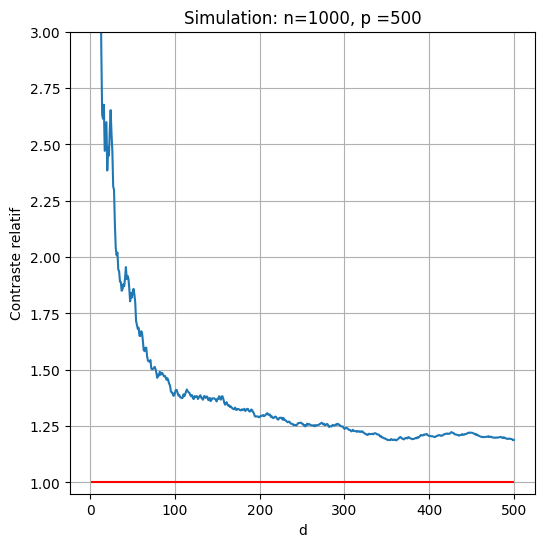

In [41]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(range(1, p+1), contrast)
ax.hlines(1, 1, p, color='red')
ax.grid()
ax.set_xlabel('d')
ax.set_ylabel('Contraste relatif')
plt.title('Simulation: n=' + str(n) +', p =' + str(p))
plt.ylim(0.95, 3)
plt.show()

On constate la décroissance du contraste relatif vers 1.

## 2. Cas d'étude : "petit" jeu de données simulé

### 2.1. Importation du jeu de données

Le jeu de données <span style="color:green">data_benchmark1</span> contient 2800 individus simulés avec 2 variables <span style="color:green">V1</span> et <span style="color:green">V2</span>.

In [42]:

bench1 = pd.read_table('donclassif.txt', sep=';', decimal='.')
bench1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      2800 non-null   float64
 1   V2      2800 non-null   float64
dtypes: float64(2)
memory usage: 43.9 KB


In [43]:
bench1.head()

,V1,V2
0,6.002504,0.031505
1,6.004021,0.063168
2,6.004545,0.094957
3,6.004069,0.126843
4,6.002587,0.158794


In [44]:
n = bench1.shape[0]
print("Nombre d'individus:", n)
p = bench1.shape[1]
print('Nombre de variables :', p)

Nombre d'individus: 2800
Nombre de variables : 2


### 2.1. Représentation graphique

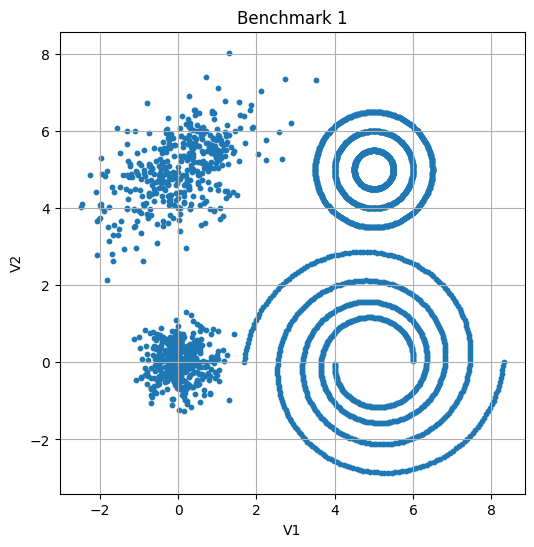

In [46]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(bench1['V1'], bench1['V2'], s=10)
ax.grid()
ax.set_xlabel('V1')
ax.set_ylabel('V2')
plt.title('Benchmark 1')
plt.show()

### 2.3. CAH

In [47]:
data_cluster = bench1

#### 2.3.1. Avec la distance euclidienne et la stratégie de Ward

In [48]:
cah_model = AgglomerativeClustering(metric='euclidean', linkage='ward', distance_threshold=0, n_clusters=None)
cah_out = cah_model.fit(data_cluster)

On représente le dendrogramme :

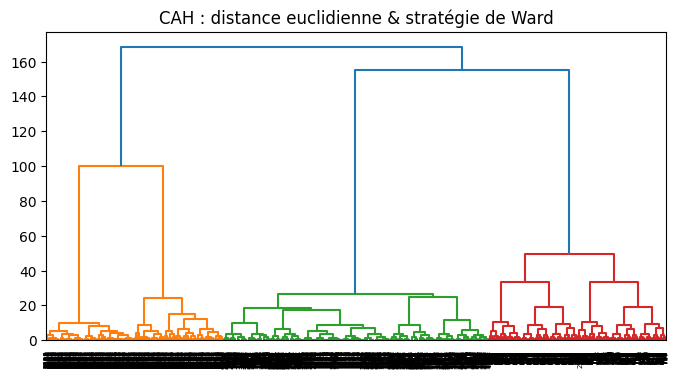

In [49]:
plt.subplots(figsize=(8, 4))
plot_dendrogram(cah_out, truncate_mode='level')
plt.title('CAH : distance euclidienne & stratégie de Ward')
plt.show()

Le dendrogramme n'est pas lisible lorsqu'il y a trop d'individus. On étudie les hauteurs correspondant au regroupement de 2 clusters depuis la partition à K clusters :

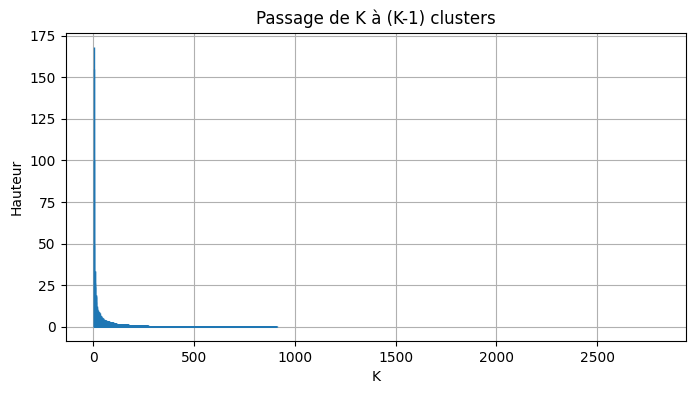

In [50]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.vlines(range(2, n+1), 0, np.flip(np.sort(cah_out.distances_)), linewidth=1)
ax.grid()
ax.set_xlabel('K')
ax.set_ylabel('Hauteur')
plt.title('Passage de K à (K-1) clusters')
plt.show()

On peut zoomer :

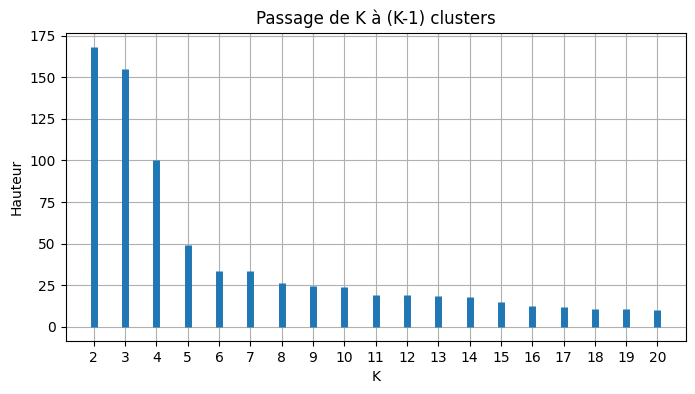

In [51]:
k_max = 20

fig, ax = plt.subplots(figsize=(8, 4))
ax.vlines(range(2, k_max+1), 0, np.flip(np.sort(cah_out.distances_))[0:k_max-1], linewidth=5)
ax.set_xticks(range(2, k_max+1))
ax.grid()
ax.set_xlabel('K')
ax.set_ylabel('Hauteur')
plt.title('Passage de K à (K-1) clusters')
plt.show()

On choisit 4 clusters selon la règle du coude :

In [52]:
k = 4

cah_model = AgglomerativeClustering(metric='euclidean', linkage='ward', n_clusters=k)
cah_out = cah_model.fit(data_cluster)

clusters = pd.DataFrame()

clusters['cluster_cah_ward'] = cah_out.fit_predict(data_cluster)
# clusters['cluster_cah_ward'] = cah_out.labels_
clusters['cluster_cah_ward'].value_counts()

cluster_cah_ward
2    1200
0     801
1     400
3     399
Name: count, dtype: int64

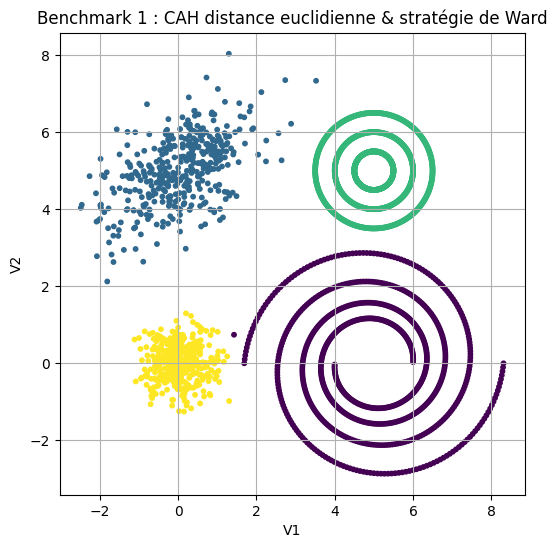

In [54]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(bench1['V1'], bench1['V2'], c=clusters['cluster_cah_ward'], s=10)
ax.grid()
ax.set_xlabel('V1')
ax.set_ylabel('V2')
plt.title('Benchmark 1 : CAH distance euclidienne & stratégie de Ward')
plt.show()

#### 2.3.2. Avec la distance euclidienne et la stratégie *complete linkage*

In [55]:
cah_model = AgglomerativeClustering(metric='euclidean', linkage='complete', distance_threshold=0, n_clusters=None)
cah_out = cah_model.fit(data_cluster)

 linkage='complete' : Distance entre clusters = plus grande distance entre deux points de chaque cluster.

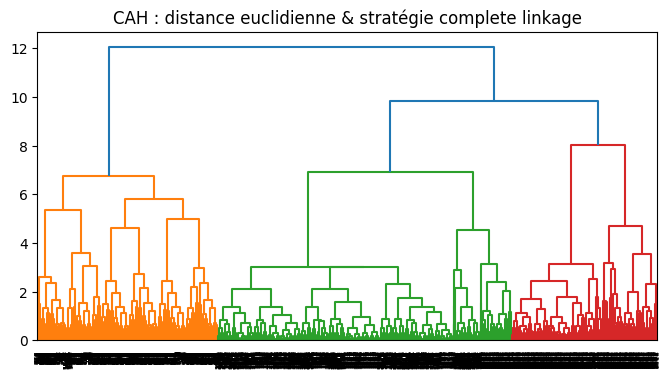

In [56]:
plt.subplots(figsize=(8, 4))
plot_dendrogram(cah_out, truncate_mode='level')
plt.title('CAH : distance euclidienne & stratégie complete linkage')
plt.show()

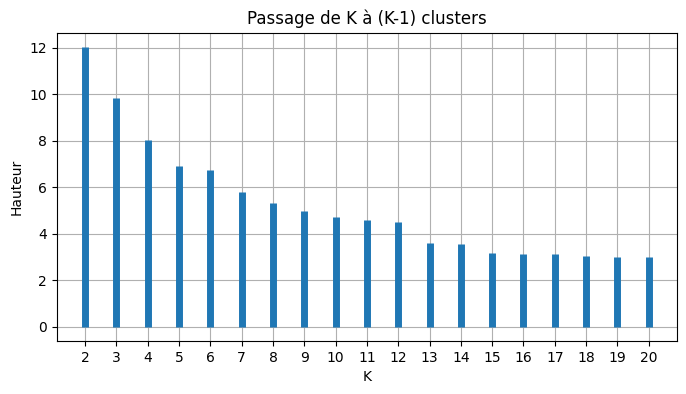

In [57]:
k_max = 20

fig, ax = plt.subplots(figsize=(8, 4))
ax.vlines(range(2, k_max+1), 0, np.flip(np.sort(cah_out.distances_))[0:k_max-1], linewidth=5)
ax.set_xticks(range(2, k_max+1))
ax.grid()
ax.set_xlabel('K')
ax.set_ylabel('Hauteur')
plt.title('Passage de K à (K-1) clusters')
plt.show()

On choisit également 3 clusters (même si le "coude" est moins clair) :

In [58]:
k = 3

cah_model = AgglomerativeClustering(metric='euclidean', linkage='complete', n_clusters=k)
cah_out = cah_model.fit(data_cluster)

clusters['cluster_cah_complete'] = cah_out.fit_predict(data_cluster)
# clusters['cluster_cah_complete'] = cah_out.labels_
clusters['cluster_cah_complete'].value_counts()

cluster_cah_complete
2    1328
1     816
0     656
Name: count, dtype: int64

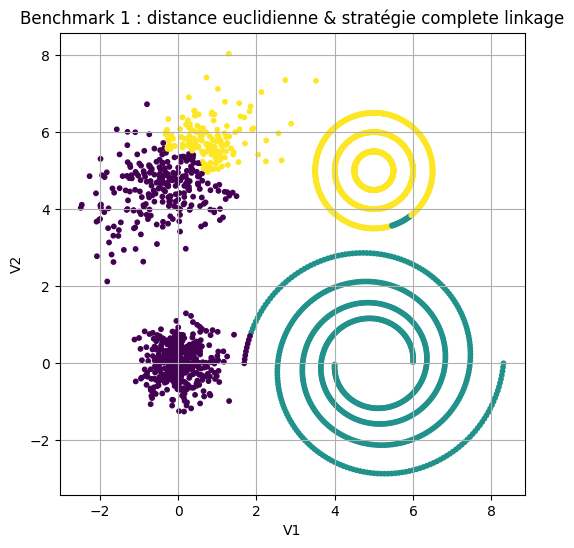

In [59]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(bench1['V1'], bench1['V2'], c=clusters['cluster_cah_complete'], s=10)
ax.grid()
ax.set_xlabel('V1')
ax.set_ylabel('V2')
plt.title('Benchmark 1 : distance euclidienne & stratégie complete linkage')
plt.show()

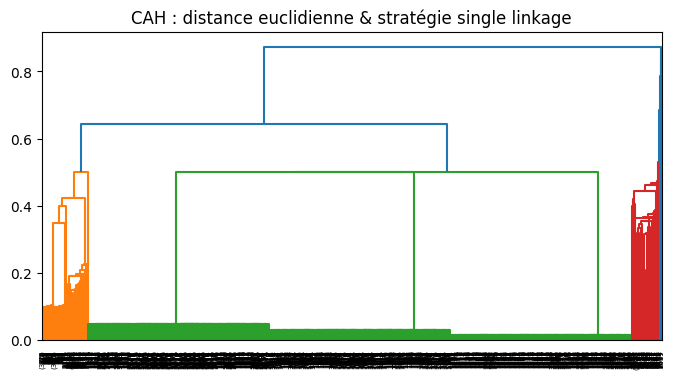

In [60]:
cah_model = AgglomerativeClustering(metric='euclidean', linkage='single', distance_threshold=0, n_clusters=None)
cah_out = cah_model.fit(data_cluster)
plt.subplots(figsize=(8, 4))
plot_dendrogram(cah_out, truncate_mode='level')
plt.title('CAH : distance euclidienne & stratégie single linkage')
plt.show()

linkage='single' : La distance entre deux clusters est la distance minimale entre deux points appartenant chacun à un cluster différent.

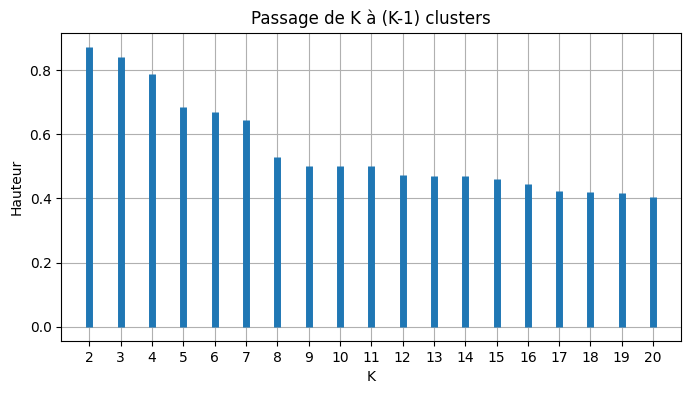

In [61]:
k_max = 20

fig, ax = plt.subplots(figsize=(8, 4))
ax.vlines(range(2, k_max+1), 0, np.flip(np.sort(cah_out.distances_))[0:k_max-1], linewidth=5)
ax.set_xticks(range(2, k_max+1))
ax.grid()
ax.set_xlabel('K')
ax.set_ylabel('Hauteur')
plt.title('Passage de K à (K-1) clusters')
plt.show()

In [62]:
k = 50

cah_model = AgglomerativeClustering(metric='euclidean', linkage='single', n_clusters=k)
cah_out = cah_model.fit(data_cluster)

clusters['cluster_cah_single'] = cah_out.fit_predict(data_cluster)
clusters['cluster_cah_single'].value_counts()

cluster_cah_single
7     400
33    400
21    400
19    400
16    400
1     398
2     335
3       8
4       7
10      4
9       3
5       2
18      2
0       2
11      2
8       2
20      2
17      1
37      1
12      1
14      1
13      1
47      1
39      1
23      1
27      1
38      1
46      1
43      1
42      1
22      1
24      1
30      1
29      1
15      1
35      1
34      1
44      1
48      1
26      1
45      1
28      1
32      1
31      1
49      1
40      1
25      1
36      1
41      1
6       1
Name: count, dtype: int64

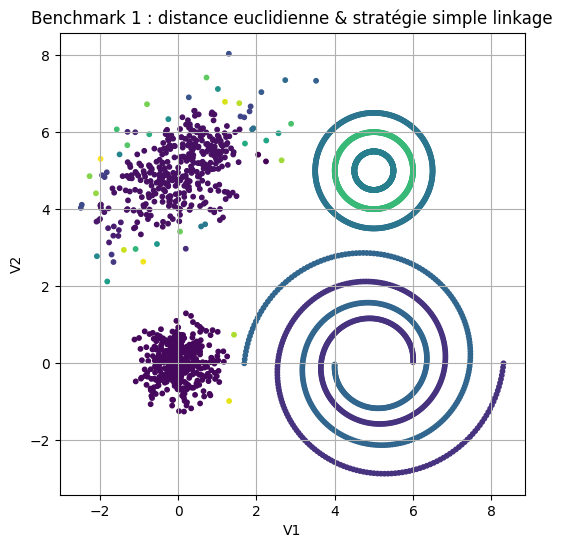

In [63]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(bench1['V1'], bench1['V2'], c=clusters['cluster_cah_single'], s=10)
ax.grid()
ax.set_xlabel('V1')
ax.set_ylabel('V2')
plt.title('Benchmark 1 : distance euclidienne & stratégie simple linkage')
plt.show()

### 2.3. $K$-means

#### Nombre de classes issu d'une CAH

On choisit le même nombre de clusters que la CAH, avec 10 initialisations :

In [64]:
k=4
kmeans_model = KMeans(init='random', max_iter=300, n_clusters=k, n_init=10)
kmeans_out = kmeans_model.fit(data_cluster)

clusters['cluster_kmeans'] = kmeans_out.fit_predict(data_cluster)
# clusters['cluster_kmeans'] = kmeans_out.labels_
clusters['cluster_kmeans'].value_counts()

cluster_kmeans
0    1244
2     708
3     454
1     394
Name: count, dtype: int64

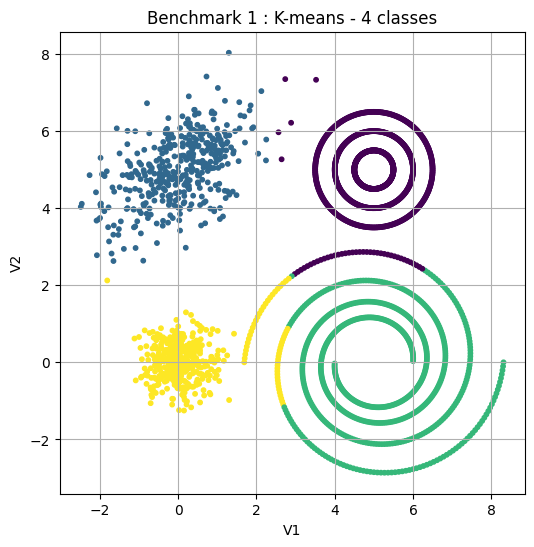

In [65]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(bench1['V1'], bench1['V2'], c=clusters['cluster_kmeans'], s=10)
ax.grid()
ax.set_xlabel('V1')
ax.set_ylabel('V2')
plt.title('Benchmark 1 : K-means - 4 classes')
plt.show()

On compare les inerties intra-classes des  𝐾
 -means obtenus pour  𝐾∈{2,…,10}
  :

In [76]:
k_max = 20

inertie_intra = pd.DataFrame(columns=['k', 'inertie_intra'])

for k in range(1, k_max+1):
    kmeans_model = KMeans(init='random', max_iter=100, n_clusters=k, n_init=10)
    kmeans_out = kmeans_model.fit(data_cluster)
    inertie_intra.loc[k-1,'k'] = k
    inertie_intra.loc[k-1,'inertie_intra'] = kmeans_out.inertia_

inertie_intra['part_inertie_intra'] = inertie_intra['inertie_intra'] / inertie_intra['inertie_intra'][0]

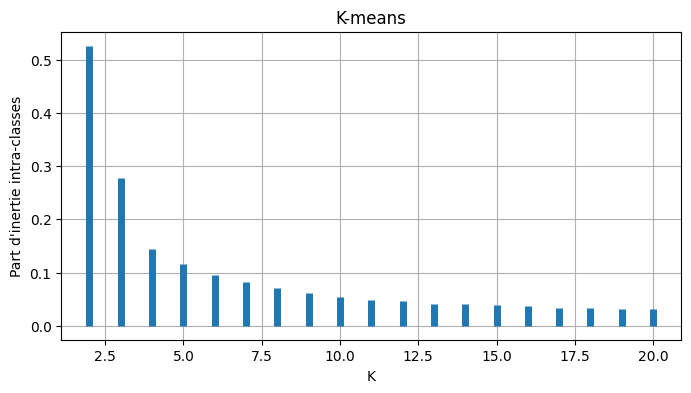

In [77]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.vlines(inertie_intra.iloc[1:]['k'], 0, inertie_intra.iloc[1:]['part_inertie_intra'], linewidth=5)
ax.grid()
ax.set_xlabel('K')
ax.set_ylabel("Part d'inertie intra-classes")
plt.title('K-means')
plt.show()

On aurait également choisi 4 clusters ici.

### 2.4 DBSCAN

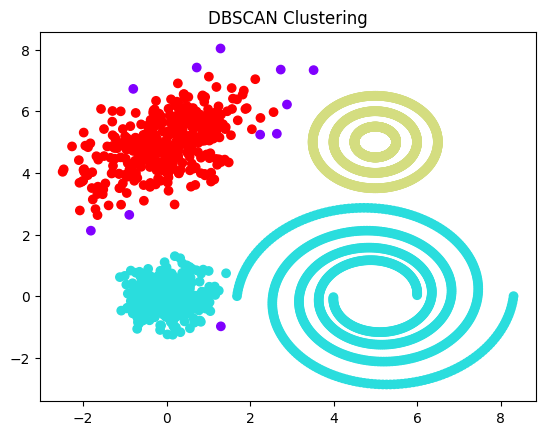

In [68]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(bench1)

clusters['cluster_dbscan'] = dbscan.fit_predict(data_cluster)
clusters['cluster_dbscan'].value_counts()

plt.scatter(bench1['V1'], bench1['V2'], c=labels_dbscan, cmap='rainbow')
plt.title("DBSCAN Clustering")
plt.show()

### 2.5 - Comparer les résultats

On compare les résultats obenus entre les CAH ward et DBSACN

In [70]:
pd.crosstab(clusters['cluster_cah_ward'], clusters['cluster_dbscan'])

cluster_dbscan,-1,0,1,2
cluster_cah_ward,,,,
0,0,801,0,0
1,10,0,0,390
2,0,0,1200,0
3,1,398,0,0


On  compare les résultats obenus entre les CAH

In [74]:
pd.crosstab(clusters['cluster_cah_ward'], clusters['cluster_cah_complete'])

cluster_cah_complete,0,1,2
cluster_cah_ward,,,
0,9,792,0
1,248,0,152
2,0,24,1176
3,399,0,0


On  compare les résultats obenus entre le CAH ward et $K$-means :

In [75]:
pd.crosstab(clusters['cluster_cah_ward'], clusters['cluster_kmeans'])

cluster_kmeans,0,1,2,3
cluster_cah_ward,,,,
0,39,0,708,54
1,5,394,0,1
2,1200,0,0,0
3,0,0,0,399


## 6. Cas d'étude : "gros" jeu de données simulé

### 6.1. Importation des données

Le jeu de données <span style="color:green">data_benchmark2</span> contient 70 000 individus simulés avec 2 variables <span style="color:green">V1</span> et <span style="color:green">V2</span>.

In [148]:
bench2 = pd.read_table('donclassif2.txt', sep=';', decimal='.')
bench2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      70000 non-null  float64
 1   V2      70000 non-null  float64
dtypes: float64(2)
memory usage: 1.1 MB


In [149]:
bench2.head()

,V1,V2
0,5.971089,-0.027773
1,6.035601,0.037879
2,5.968887,-0.027694
3,5.953036,-0.042402
4,6.034341,0.040049


In [150]:
n = bench2.shape[0]
print("Nombre d'individus:", n)
p = bench2.shape[1]
print('Nombre de variables :', p)

Nombre d'individus: 70000
Nombre de variables : 2


###  Représentation graphique

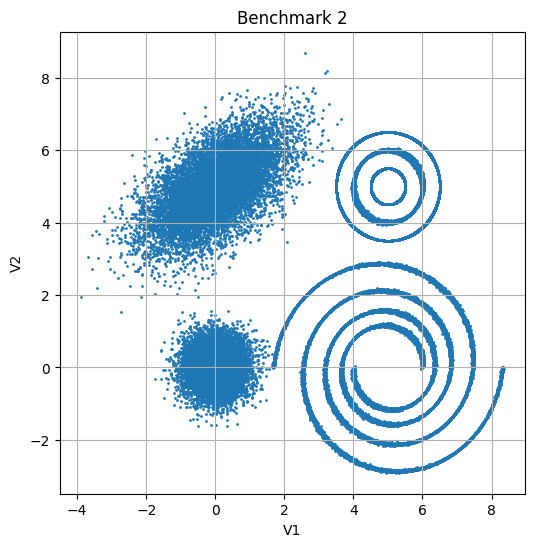

In [151]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(bench2['V1'], bench2['V2'], s=1)
ax.grid()
ax.set_xlabel('V1')
ax.set_ylabel('V2')
plt.title('Benchmark 2')
plt.show()

### 6.2. $K$-means et CAH

Pour ce jeu de données, beaucoup plus volumineux (70 000 individus), une classification non supervisée via $K$-means est réaliste, contrairement à une CAH. Pour adopter la méthode combinée CAH / $K$-means précédente, il faut au préalable réduire la dimension via un $K$-means :

1. Lancer un $K$-means sur les $n$ individus avec $K_1\ll n$ clusters.

2. Lancer une CAH sur les $K_1$ centroïdes obtenus à l'étape précédente, et choisir alors un nombre de clusters $K_2$.

3. Lancer un $K$-means sur les $n$ individus avec $K_2$ clusters.

In [152]:
data_cluster =  bench2

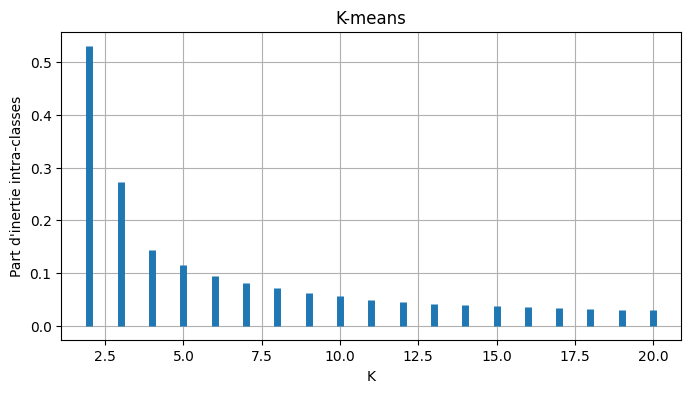

In [153]:
k_max = 20

inertie_intra = pd.DataFrame(columns=['k', 'inertie_intra'])

for k in range(1, k_max+1):
    kmeans_model = KMeans(init='random', max_iter=100, n_clusters=k, n_init=10)
    kmeans_out = kmeans_model.fit(data_cluster)
    inertie_intra.loc[k-1,'k'] = k
    inertie_intra.loc[k-1,'inertie_intra'] = kmeans_out.inertia_

inertie_intra['part_inertie_intra'] = inertie_intra['inertie_intra'] / inertie_intra['inertie_intra'][0]
fig, ax = plt.subplots(figsize=(8, 4))
ax.vlines(inertie_intra.iloc[1:]['k'], 0, inertie_intra.iloc[1:]['part_inertie_intra'], linewidth=5)
ax.grid()
ax.set_xlabel('K')
ax.set_ylabel("Part d'inertie intra-classes")
plt.title('K-means')
plt.show()

In [84]:
cah_model = AgglomerativeClustering(metric='euclidean', linkage='complete', distance_threshold=0, n_clusters=None)
cah_out = cah_model.fit(data_cluster)
plt.subplots(figsize=(8, 4))
plot_dendrogram(cah_out, truncate_mode='level')
plt.title('CAH : distance euclidienne & stratégie complete linkage')
plt.show()

MemoryError: unable to allocate array data.

#### Kmeans avec bcp de groupe

In [154]:
k1 = 5000

kmeans1_model = KMeans(init='random', max_iter=100, n_clusters=k1, n_init=1)
kmeans_out1 = kmeans1_model.fit(data_cluster)

centroides = kmeans_out1.cluster_centers_

In [155]:
centroides.shape

(5000, 2)

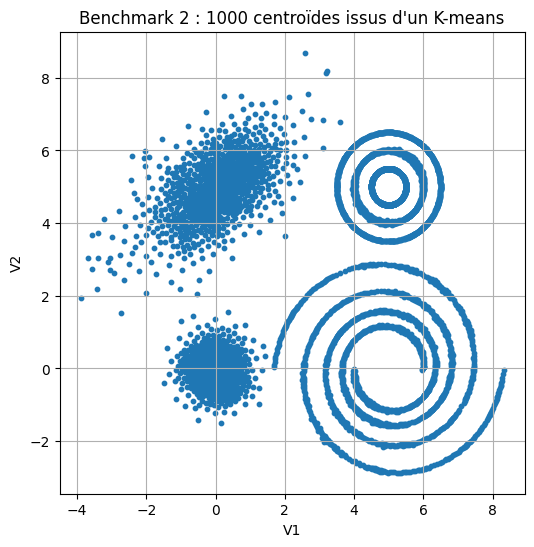

In [156]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(centroides[:,0], centroides[:,1], s=10)
ax.grid()
ax.set_xlabel('V1')
ax.set_ylabel('V2')
plt.title("Benchmark 2 : 1000 centroïdes issus d'un K-means")
plt.show()

### CAH avec les centroïdes

In [163]:
cah_model = AgglomerativeClustering(metric='euclidean', linkage='ward', distance_threshold=0, n_clusters=None)
cah_centroides = cah_model.fit(centroides)

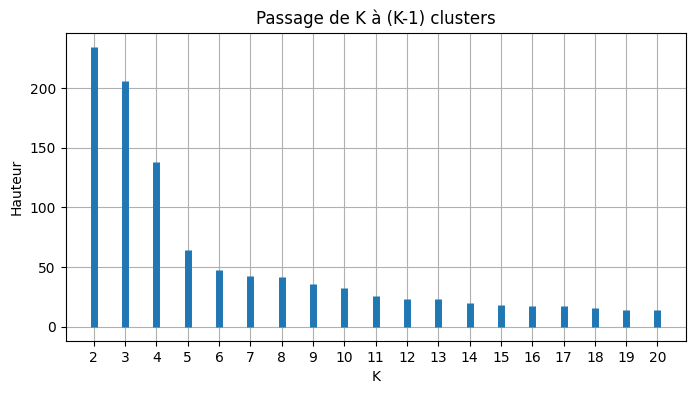

In [164]:
k_max = 20

fig, ax = plt.subplots(figsize=(8, 4))
ax.vlines(range(2, k_max+1), 0, np.flip(np.sort(cah_centroides.distances_))[0:k_max-1], linewidth=5)
ax.set_xticks(range(2, k_max+1))
ax.grid()
ax.set_xlabel('K')
ax.set_ylabel('Hauteur')
plt.title('Passage de K à (K-1) clusters')
plt.show()

On choisit 4 cluster

In [169]:
cah_model = AgglomerativeClustering( n_clusters=4)
cah_centroides = cah_model.fit(centroides)

clusters = pd.DataFrame()

clusters['cluster_cah'] = cah_centroides.fit_predict(centroides)
clusters['cluster_cah'].value_counts()

cluster_cah
2    2039
0    1413
1     788
3     760
Name: count, dtype: int64

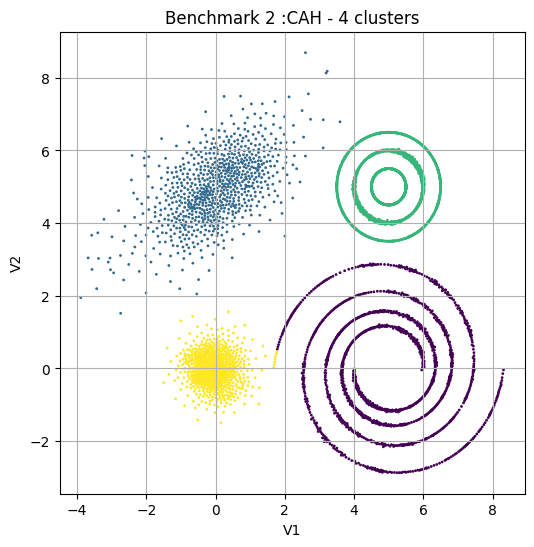

In [170]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(centroides[:,0], centroides[:,1], c=clusters['cluster_cah'], s=1)
ax.grid()
ax.set_xlabel('V1')
ax.set_ylabel('V2')
plt.title('Benchmark 2 :CAH - 4 clusters')
plt.show()

## 6.3 - Kmeans

In [171]:
k2 = 4

kmeans2_model = KMeans(init='k-means++', max_iter=300, n_clusters=k2, n_init=10)
kmeans_out2 = kmeans2_model.fit(bench2)


clusters = pd.DataFrame()

clusters['cluster_kmeans'] = kmeans_out2.fit_predict(bench2)
clusters['cluster_kmeans'].value_counts()

cluster_kmeans
1    31030
0    17781
2    11281
3     9908
Name: count, dtype: int64

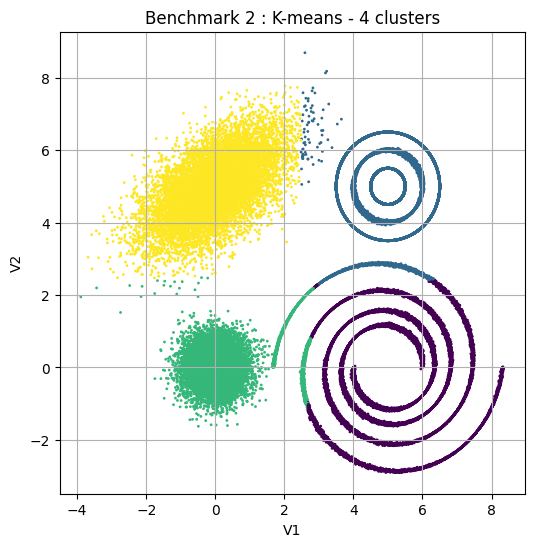

In [172]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(bench2['V1'], bench2['V2'], c=clusters['cluster_kmeans'], s=1)
ax.grid()
ax.set_xlabel('V1')
ax.set_ylabel('V2')
plt.title('Benchmark 2 : K-means - 4 clusters')
plt.show()

## 6.4 - DBSCAN

### Choix des paramètres optimaux pour DBSCAN :

* eps = rayon du voisinage

* min_samples = nombre minimal de points dans ce voisinage pour former un "core point

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# min_samples suggéré : généralement log(n), ou entre 5 et 20
min_samples = 10

# Ajuste à tes données : bench2 ou data_cluster
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(bench2)
distances, indices = neighbors_fit.kneighbors(bench2)

# On prend la distance au min_samples-ième plus proche voisin
distances = np.sort(distances[:, min_samples-1])

plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.title("k-distance graph")
plt.xlabel("Points triés")
plt.ylabel(f"Distance au {min_samples}ème plus proche voisin")
plt.grid(True)
plt.show()

* Une fois le coude trouvé, essaie différents eps autour de cette valeur et fais varier min_samples (entre 5 et 20 généralement) pour voir l'effet sur :

* Le nombre de clusters

* Le nombre de bruits (label = -1)

* La Silhouette Score (optionnel si > 1 cluster)

### Recherche des paramètres optimaux très lente

In [174]:
from sklearn.metrics import silhouette_score

for eps in [0.16,0.2,0.3,0.4,0.5]:
    for min_samples in [10, 20, 30]:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(bench2)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        if n_clusters > 1:
            score = silhouette_score(bench2, labels)
        else:
            score = -1
        
        print(f"eps={eps}, min_samples={min_samples} ➤ clusters={n_clusters}, bruit={n_noise}, silhouette={score:.3f}")

eps=0.1, min_samples=10 ➤ clusters=20, bruit=1093, silhouette=0.008
eps=0.1, min_samples=20 ➤ clusters=12, bruit=2288, silhouette=0.062
eps=0.1, min_samples=30 ➤ clusters=10, bruit=3685, silhouette=0.088
eps=0.12, min_samples=10 ➤ clusters=11, bruit=726, silhouette=0.101
eps=0.12, min_samples=20 ➤ clusters=9, bruit=1653, silhouette=0.098
eps=0.12, min_samples=30 ➤ clusters=8, bruit=2402, silhouette=0.106
eps=0.14, min_samples=10 ➤ clusters=9, bruit=505, silhouette=0.132
eps=0.14, min_samples=20 ➤ clusters=8, bruit=1182, silhouette=0.146
eps=0.14, min_samples=30 ➤ clusters=7, bruit=1759, silhouette=0.172
eps=0.15, min_samples=10 ➤ clusters=8, bruit=439, silhouette=0.142
eps=0.15, min_samples=20 ➤ clusters=7, bruit=930, silhouette=0.182
eps=0.15, min_samples=30 ➤ clusters=7, bruit=1532, silhouette=0.175
eps=0.16, min_samples=10 ➤ clusters=9, bruit=386, silhouette=0.119
eps=0.16, min_samples=20 ➤ clusters=7, bruit=800, silhouette=0.184
eps=0.16, min_samples=30 ➤ clusters=7, bruit=1346, si

✅ Choix final :
    
* Tu choisis la combinaison qui :

* Donne plusieurs clusters (pas tous -1 ni tous 0)

* Avec peu de bruit (-1)

* Et un Silhouette Score raisonnable (> 0.25–0.3 si possible)

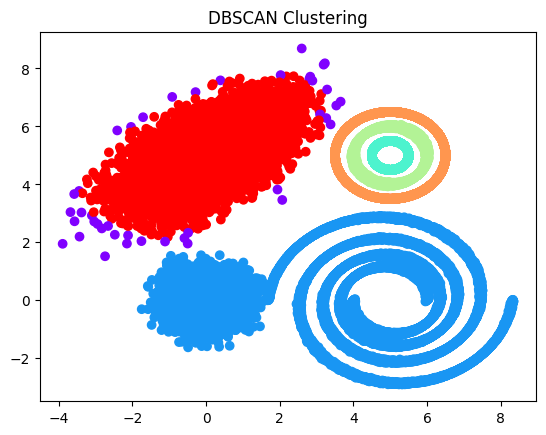

In [175]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.4, min_samples=20)
labels_dbscan = dbscan.fit_predict(bench2)

clusters['cluster_dbscan'] = dbscan.fit_predict(data_cluster)
clusters['cluster_dbscan'].value_counts()

plt.scatter(bench2['V1'], bench2['V2'], c=labels_dbscan, cmap='rainbow')
plt.title("DBSCAN Clustering")
plt.show()

### 6.5 Comparer

In [176]:
pd.crosstab(clusters['cluster_dbscan'], clusters['cluster_kmeans'])

cluster_kmeans,0,1,2,3
cluster_dbscan,,,,
-1,0,12,11,19
0,17781,958,11261,0
1,0,10000,0,0
2,0,10000,0,0
3,0,10000,0,0
4,0,60,9,9889


## 3. Cas d'étude : températures moyennes mensuelles de villes

### 3.1. Importation des données

Le jeu de données <span style="color:green">average_temperatures_cities</span> contient 451 observations, pour des villes, des 18 variables suivantes :
* <span style="color:green">country</span> : pays,
* <span style="color:green">city</span> : ville,
* <span style="color:green">temp_m01</span>, ..., <span style="color:green">temp_m12</span> : températures moyennes en janvier, ..., décembre (en *$^{\circ} C$*),
* <span style="color:green">temp_y</span> : température moyenne annuelle (en *$^{\circ} C$*),
* <span style="color:green">continent</span> : continent,
* <span style="color:green">longitude</span> : longitude,
* <span style="color:green">latitude</span> : latitude.

In [19]:

temp = pd.read_table('average_temperatures_cities.csv',
                     sep=',',
                     decimal='.')
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451 entries, 0 to 450
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   country    451 non-null    object 
 1   city       451 non-null    object 
 2   temp_m01   451 non-null    float64
 3   temp_m02   451 non-null    float64
 4   temp_m03   451 non-null    float64
 5   temp_m04   451 non-null    float64
 6   temp_m05   451 non-null    float64
 7   temp_m06   451 non-null    float64
 8   temp_m07   451 non-null    float64
 9   temp_m08   451 non-null    float64
 10  temp_m09   451 non-null    float64
 11  temp_m10   451 non-null    float64
 12  temp_m11   451 non-null    float64
 13  temp_m12   451 non-null    float64
 14  temp_y     451 non-null    float64
 15  continent  451 non-null    object 
 16  longitude  451 non-null    float64
 17  latitude   451 non-null    float64
dtypes: float64(15), object(3)
memory usage: 63.6+ KB


In [20]:
temp.head()

,country,city,temp_m01,temp_m02,temp_m03,temp_m04,temp_m05,temp_m06,temp_m07,temp_m08,temp_m09,temp_m10,temp_m11,temp_m12,temp_y,continent,longitude,latitude
0,Algeria,Algiers,11.2,11.9,12.8,14.7,17.7,21.3,24.6,25.2,23.2,19.4,15.2,12.1,17.4,Africa,3.060188,36.775361
1,Algeria,Tamanrasset,12.8,15.0,18.1,22.2,26.1,28.9,28.7,28.2,26.5,22.4,17.3,13.9,21.7,Africa,4.320844,24.375344
2,Algeria,Reggane,16.0,18.2,23.1,27.9,32.2,36.4,39.8,38.4,35.5,29.2,22.0,17.8,28.3,Africa,0.175151,26.720727
3,Angola,Luanda,26.7,28.5,28.6,28.2,27.0,23.9,22.1,22.1,23.5,25.2,26.7,26.9,25.8,Africa,13.243951,-8.827270
4,Benin,Cotonou,27.3,28.5,28.9,28.6,27.8,26.5,25.8,25.6,26.0,26.7,27.6,27.3,27.2,Africa,2.425251,6.367695


In [21]:
n = temp.shape[0]
print("Nombre d'individus:", n)
p = temp.shape[1]
print('Nombre de variables :', p)

Nombre d'individus: 451
Nombre de variables : 18


### Représentation graphique

On représente les villes sur une carte :

In [22]:
fig = px.scatter_geo(temp,
                     lat='latitude', lon='longitude',
                     hover_name='city',
                     hover_data={'city':False, 'latitude':True, 'longitude':True},
                     projection='natural earth')
fig.update_layout(width=1000, height=700, title='Villes')
fig.show()

### 3.2. CAH Clustering sur les données brutes

In [23]:
data_cluster = temp.drop(['country', 'city', 'temp_y', 'continent','latitude', 'longitude'], axis=1)

In [24]:
cah_model = AgglomerativeClustering(metric='euclidean', linkage='ward', distance_threshold=0, n_clusters=None)
cah_out = cah_model.fit(data_cluster)

temp['cluster_cah_brut'] = kmeans_out.fit_predict(data_cluster)
temp['cluster_cah_brut'].value_counts()

cluster_cah_brut
0    185
1    135
2     77
3     54
Name: count, dtype: int64

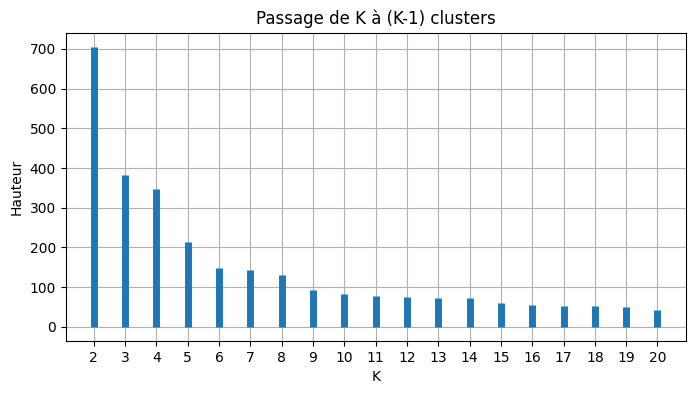

In [25]:
k_max = 20

fig, ax = plt.subplots(figsize=(8, 4))
ax.vlines(range(2, k_max+1), 0, np.flip(np.sort(cah_out.distances_))[0:k_max-1], linewidth=5)
ax.set_xticks(range(2, k_max+1))
ax.grid()
ax.set_xlabel('K')
ax.set_ylabel('Hauteur')
plt.title('Passage de K à (K-1) clusters')
plt.show()

On choisit 4 clusters et on lance un $K$-means :

In [61]:
temp['cluster_cah_brut_str'] = (temp['cluster_cah_brut']).astype(str)

fig = px.scatter_geo(temp.sort_values(by='cluster_cah_brut_str'),
                     lat='latitude', lon='longitude',
                     hover_name='city',
                     hover_data={'city':False, 'latitude':True, 'longitude':True, 'cluster_cah_brut_str':False},
                     color='cluster_cah_brut_str',
                     projection='natural earth')
fig.update_layout(width=1000, height=700,
                  title='Villes',
                  legend_title_text='CAH Cluster (sans normalisation)')
fig.show()

## CAH avec Normalisation

In [62]:
norm = StandardScaler(with_mean=True, with_std=True)
data_cluster_norm = norm.fit_transform(data_cluster)

In [63]:
cah_model_norm = AgglomerativeClustering(metric='euclidean', linkage='ward', distance_threshold=0, n_clusters=None)
cah_out_norm = cah_model.fit(data_cluster_norm)

temp['cluster_cah_norm'] = cah_out_norm.fit_predict(data_cluster_norm)

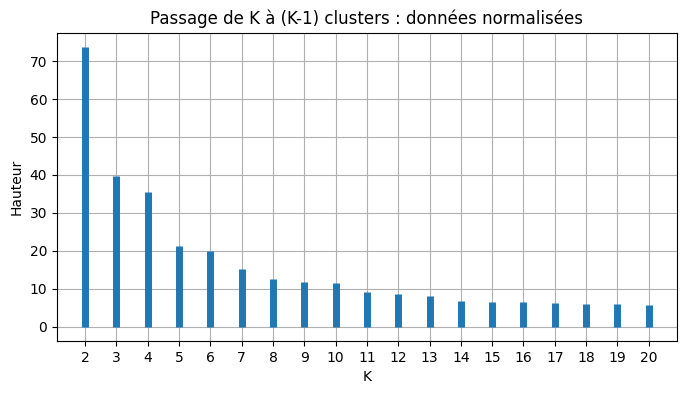

In [64]:
k_max = 20

fig, ax = plt.subplots(figsize=(8, 4))
ax.vlines(range(2, k_max+1), 0, np.flip(np.sort(cah_out_norm.distances_))[0:k_max-1], linewidth=5)
ax.set_xticks(range(2, k_max+1))
ax.grid()
ax.set_xlabel('K')
ax.set_ylabel('Hauteur')
plt.title('Passage de K à (K-1) clusters : données normalisées')
plt.show()

On choisit 4 clusters

In [65]:
temp['cluster_cah_norm_str'] = (temp['cluster_cah_norm']).astype(str)

fig = px.scatter_geo(temp.sort_values(by='cluster_cah_norm_str'),
                     lat='latitude', lon='longitude',
                     hover_name='city',
                     hover_data={'city':False, 'latitude':True, 'longitude':True, 'cluster_cah_norm_str':False},
                     color='cluster_cah_norm_str',
                     projection='natural earth')
fig.update_layout(width=1000, height=700,
                  title='Villes',
                  legend_title_text='CAH Cluster (avec normalisation)')
fig.show()

## 3.3 Kmeans

In [66]:
k = 4

kmeans_model = KMeans(init='k-means++', max_iter=300, n_clusters=k, n_init=20)
kmeans_out = kmeans_model.fit(data_cluster)

temp['cluster_kmeans_brut'] = kmeans_out.fit_predict(data_cluster)
temp['cluster_kmeans_brut'].value_counts()

cluster_kmeans_brut
0    185
1    135
2     77
3     54
Name: count, dtype: int64

On extrait les villes contenues dans chacun des clusters :

In [67]:
for i in range(k):
    print('\n', 'Cluster', i)
    print(list(temp[temp['cluster_kmeans_brut'] == i].city))


 Cluster 0
['Tamanrasset', 'Reggane', 'Luanda', 'Cotonou', 'Parakou', 'Kandi', 'Maun', 'Ouagadougou', 'Ouahigouya', 'Bujumbura', 'Garoua', 'Ngaoundéré', 'Douala', 'Yaoundé', 'Praia', 'Bangui', 'Birao', "N'Djamena", 'Abéché', 'Kinshasa', 'Djibouti', 'Cairo', 'Bata', 'Malabo', 'Assab', "Mek'ele", 'Libreville', 'Port-Gentil', 'Banjul', 'Accra', 'Tamale', 'Kumasi', 'Conakry', 'Kankan', 'Bissau', 'Gagnoa', 'Bouaké', 'Abidjan', 'Odienné', 'Mombasa', 'Garissa', 'Lodwar', 'Toamasina', 'Antsiranana', 'Mahajanga', 'Toliara', 'Karonga', 'Blantyre', 'Ségou', 'Timbuktu', 'Bamako', 'Nouadhibou', 'Nouakchott', 'Maputo', 'Niamey', 'Lagos', 'Makurdi', 'Jos', 'Kano', 'Sokoto', 'Brazzaville', 'Pointe-Noire', 'Dolisie', 'Dakar', 'Thiès', 'Bosaso', 'Hargeisa', 'Mogadishu', 'Juba', 'Wau', 'Port Sudan', 'Khartoum', 'Dar es Salaam', 'Zanzibar City', 'Tabora', 'Dodoma', 'Lomé', 'Mango', 'Kampala', 'Entebbe', 'Livingstone', 'Manama', 'Dhaka', 'Phnom Penh', 'Guangzhou', 'Dili', 'Hong Kong', 'New Delhi', 'Kolkat

On colorie les villes sur la carte  en fonction de leur cluster :

In [68]:
temp['cluster_kmeans_brut_str'] = (temp['cluster_kmeans_brut']).astype(str)

fig = px.scatter_geo(temp.sort_values(by='cluster_kmeans_brut_str'),
                     lat='latitude', lon='longitude',
                     hover_name='city',
                     hover_data={'city':False, 'latitude':True, 'longitude':True, 'cluster_kmeans_brut_str':False},
                     color='cluster_kmeans_brut_str',
                     projection='natural earth')
fig.update_layout(width=1000, height=700,
                  title='Villes',
                  legend_title_text='K means Cluster (sans normalisation)')
fig.show()

### 3.3. M means Clustering sur les données normalisées

In [69]:
norm = StandardScaler(with_mean=True, with_std=True)
data_cluster_norm = norm.fit_transform(data_cluster)

In [70]:
k = 4

kmeans_model_norm = KMeans(init='k-means++', max_iter=300, n_clusters=k, n_init=20)
kmeans_out_norm = kmeans_model_norm.fit(data_cluster_norm)

temp['cluster_kmeans_norm'] = kmeans_out_norm.fit_predict(data_cluster_norm)

In [71]:
temp['cluster_kmeans_norm_str'] = (temp['cluster_kmeans_norm']).astype(str)

fig = px.scatter_geo(temp.sort_values(by='cluster_kmeans_norm_str'),
                     lat='latitude', lon='longitude',
                     hover_name='city',
                     hover_data={'city':False, 'latitude':True, 'longitude':True, 'cluster_kmeans_norm_str':False},
                     color='cluster_kmeans_norm_str',
                     projection='natural earth')
fig.update_layout(width=1000, height=700,
                  title='Villes',
                  legend_title_text='K means Cluster (normalisation)')
fig.show()

## 3.4 DBSCAN

In [81]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=5)
labels_dbscan = dbscan.fit_predict(data_cluster)
temp['cluster_dbscan_brut'] = dbscan.fit_predict(data_cluster)

In [82]:
temp['cluster_dbscan_brut_str'] = (temp['cluster_dbscan_brut']).astype(str)

fig = px.scatter_geo(temp.sort_values(by='cluster_dbscan_brut_str'),
                     lat='latitude', lon='longitude',
                     hover_name='city',
                     hover_data={'city':False, 'latitude':True, 'longitude':True, 'cluster_dbscan_brut_str':False},
                     color='cluster_dbscan_brut_str',
                     projection='natural earth')
fig.update_layout(width=1000, height=700,
                  title='Villes',
                  legend_title_text='DBSCAN Cluster (sans normalisation)')
fig.show()

## 3.5 - Comparer

Kemans vs cah (brut)

In [83]:
pd.crosstab(temp['cluster_kmeans_brut'], temp['cluster_cah_brut'])

cluster_cah_brut,0,1,2,3
cluster_kmeans_brut,,,,
0,185,0,0,0
1,0,135,0,0
2,0,0,77,0
3,0,0,0,54


In [85]:
pd.crosstab(temp['cluster_kmeans_norm'], temp['cluster_cah_brut'])

cluster_cah_brut,0,1,2,3
cluster_kmeans_norm,,,,
0,2,104,0,0
1,0,30,0,54
2,178,0,0,0
3,5,1,77,0


## 3.6. Déja fait plus haut.

On colorie les villes sur la carte  en fonction de leur cluster :

In [87]:
temp['cluster_kmeans_norm_str'] = (temp['cluster_kmeans_norm']).astype(str)

fig = px.scatter_geo(temp.sort_values(by='cluster_kmeans_norm_str'),
                     lat='latitude', lon='longitude',
                     hover_name='city',
                     hover_data={'city':False, 'latitude':True, 'longitude':True, 'cluster_kmeans_norm_str':False},
                     color='cluster_kmeans_norm_str',
                     projection='natural earth')
fig.update_layout(width=1200, height=700,
                  title='Villes',
                  legend_title_text='Kmeans Cluster (après normalisation)')
fig.show()

## On ajoute une EM (Gaussian Mixture Model)

In [92]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=5, random_state=42)
temp['cluster_em_brut'] = gmm.fit_predict(data_cluster)

In [93]:
temp['cluster_em_brut_str'] = (temp['cluster_em_brut']).astype(str)

fig = px.scatter_geo(temp.sort_values(by='cluster_em_brut_str'),
                     lat='latitude', lon='longitude',
                     hover_name='city',
                     hover_data={'city':False, 'latitude':True, 'longitude':True, 'cluster_em_brut_str':False},
                     color='cluster_em_brut_str',
                     projection='natural earth')
fig.update_layout(width=1200, height=700,
                  title='Villes',
                  legend_title_text='EM Cluster (Sans normalisation)')
fig.show()

## EM sur le premier jeux de données

In [99]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

component_1 = bench1["V1"]
component_2 = bench1["V2"]
X = bench1.to_numpy()
print(X.shape)

def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(2, 10),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(bench1)

(2800, 2)


GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(2, 10)},
             scoring=<function gmm_bic_score at 0x000002FAF9C1C2C0>)

In [100]:
df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head()

,Number of components,Type of covariance,BIC score
8,2,tied,5927.689034
0,2,spherical,6482.117643
10,4,tied,6493.043749
2,4,spherical,6670.956962
24,2,full,6806.361597


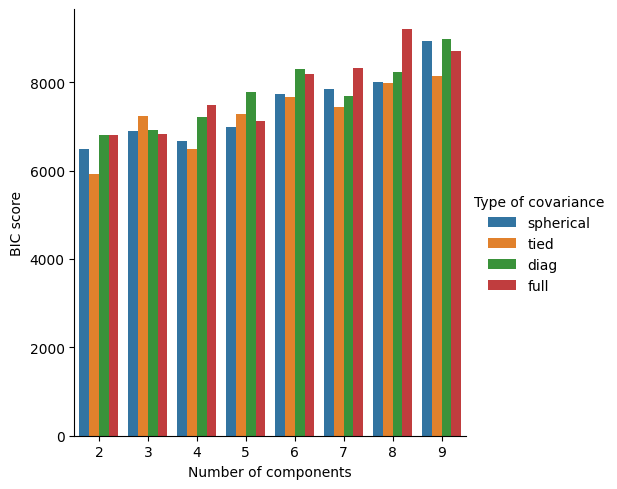

In [101]:
import seaborn as sns
sns.catplot(
    data=df,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()

<Axes: xlabel='V1', ylabel='V2'>

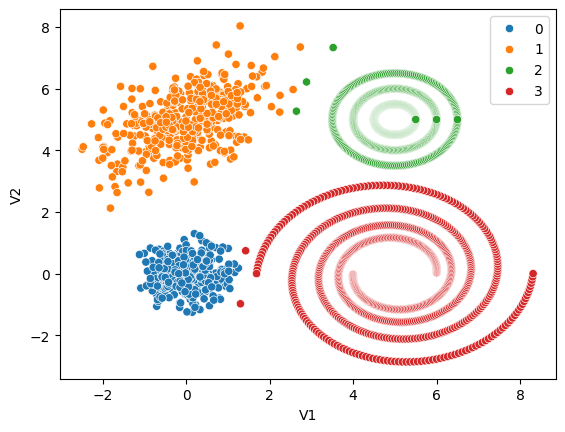

In [102]:
gmm = GaussianMixture(n_components=4, covariance_type="full").fit(bench1)
labels = gmm.predict(bench1)
sns.scatterplot(data=bench1,x="V1",y="V2",hue=labels,palette="tab10")

## 4 - ACP

### 4.1- Importerles données

In [105]:
import pandas as pd

url = "https://raw.githubusercontent.com/R-stat-sc-donnees/R-stat-sc-donnees.github.io/master/decathlon.csv"
df = pd.read_csv(url,sep=';')
df.head()

,Unnamed: 0,100m,Longueur,Poids,Hauteur,400m,110m H,Disque,Perche,Javelot,1500m,Classement,Points,Competition
0,Sebrle,10.85,7.84,16.36,2.12,48.36,14.05,48.72,5.0,70.52,280.01,1,8893,JO
1,Clay,10.44,7.96,15.23,2.06,49.19,14.13,50.11,4.9,69.71,282.00,2,8820,JO
2,Karpov,10.50,7.81,15.93,2.09,46.81,13.97,51.65,4.6,55.54,278.11,3,8725,JO
3,Macey,10.89,7.47,15.73,2.15,48.97,14.56,48.34,4.4,58.46,265.42,4,8414,JO
4,Warners,10.62,7.74,14.48,1.97,47.97,14.01,43.73,4.9,55.39,278.05,5,8343,JO


### 4.2 Sélectionner les variables à utiliser

In [107]:
X = df.loc[:, ['100m', 'Longueur', 'Poids', 'Hauteur', '400m',
               '110m H', 'Disque', 'Perche', 'Javelot', '1500m']]

### 4.3-  Sélectionner le nombre d’axes (dimensions)

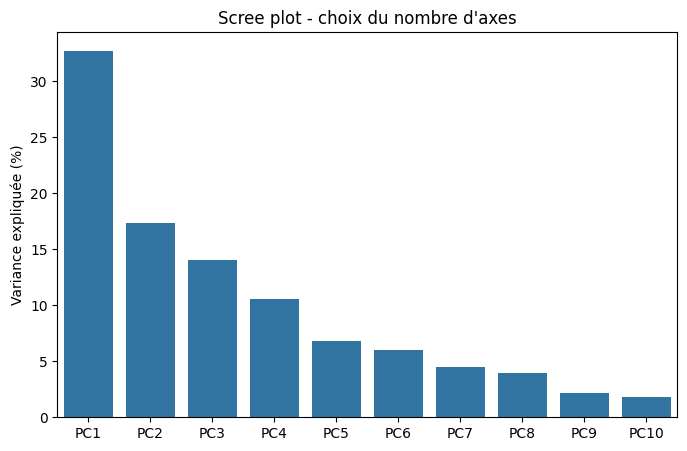

In [108]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Standardiser
X_scaled = StandardScaler().fit_transform(X)

# ACP
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Variance expliquée
explained_var = pca.explained_variance_ratio_

# Graphique du scree plot
plt.figure(figsize=(8,5))
sns.barplot(x=[f"PC{i+1}" for i in range(len(explained_var))], y=explained_var*100)
plt.ylabel("Variance expliquée (%)")
plt.title("Scree plot - choix du nombre d'axes")
plt.show()

* On garde les axes qui expliquent ~80% de la variance (souvent les 2 ou 3 premiers suffisent).

### 4.4 - Commenter la représentation des variables (cercle de corrélation)

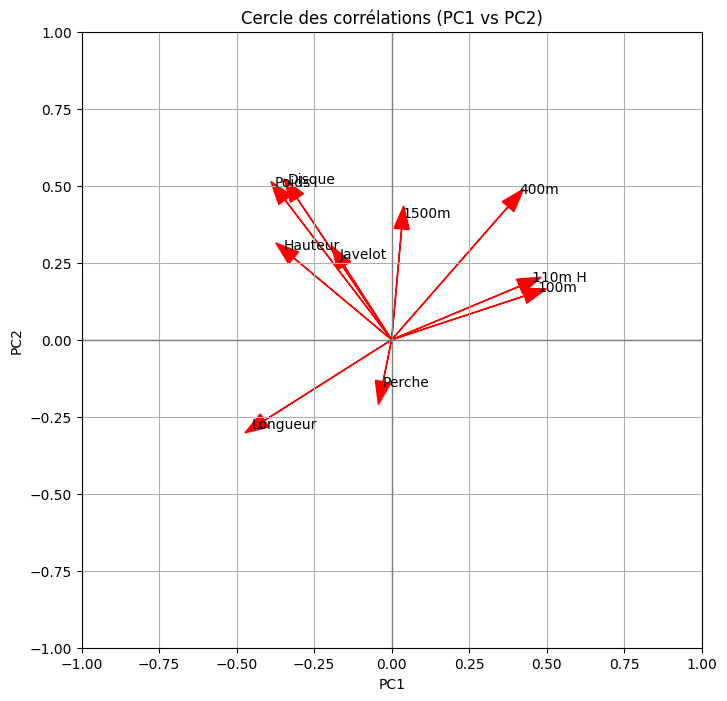

In [109]:
import numpy as np

# Cercle des corrélations
pcs = pca.components_
variables = X.columns

plt.figure(figsize=(8,8))
for i in range(len(variables)):
    plt.arrow(0, 0, pcs[0, i], pcs[1, i], head_width=0.05, color='red')
    plt.text(pcs[0, i]*1.1, pcs[1, i]*1.1, variables[i], color='black')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title("Cercle des corrélations (PC1 vs PC2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid()
plt.show()

* Les épreuves corrélées positivement entre elles sont proches sur le cercle.
---

* 1. Axes principaux :

PC1 (axe horizontal) et PC2 (axe vertical) sont les deux premières composantes principales.

Ils résument une grande partie de la variance.

* Les flèches longues proches du cercle sont bien représentées (cos² élevé) :
---

Variable--------------------------------------------------------> Interprétation

---
400m, 110m H, 100m	Fortement corrélées à PC1 ----> expriment la performance en courses rapides.

---

Disque, Javelot, Hauteur	Corrélées à PC2 ----> expriment plutôt la dimension puissance/saut.

---

Longueur	À l’opposé des courses rapides sur PC1 (corrélation négative).

---

Perche	Peu corrélée (proche du centre) → pas bien expliquée par PC1/PC2.

---

* 100m et 110m H sont très corrélées.

* Longueur est en opposition à 400m → certains athlètes peuvent performer sur l’un mais pas l’autre.

* Perche est neutre ici → sa variation est mieux expliquée par un axe ultérieur (PC3/PC4).

### 4.5 - Représentation des individus + cos²

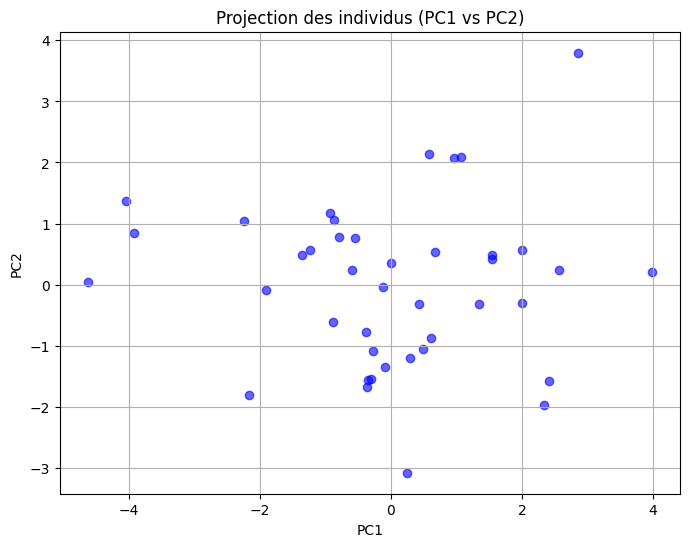

In [110]:
# Graphique des individus
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='blue', alpha=0.6)
plt.title("Projection des individus (PC1 vs PC2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid()
plt.show()

* Clustering possible : certains athlètes se regroupent selon leur profil (sprinteurs vs endurants).

* Cos² à calculer pour filtrer ceux bien représentés :

In [111]:
cos2 = (X_pca[:, :2] ** 2).sum(axis=1) / (X_pca ** 2).sum(axis=1)
df["cos2"] = cos2

* On peut filtrer : df[df["cos2"] > 0.5] pour voir les individus bien représentés.

In [114]:
df_bien_rep = df[df['cos2'] > 0.5]

# Affichage des individus bien représentés
print(df_bien_rep[['Unnamed: 0', 'Competition', 'cos2']])

     Unnamed: 0 Competition      cos2
0        Sebrle          JO  0.774953
1          Clay          JO  0.743637
2        Karpov          JO  0.851819
3         Macey          JO  0.515088
4       Warners          JO  0.896415
18        Drews          JO  0.815972
23      Lorenzo          JO  0.674159
24    Karlivans          JO  0.555734
26        Uldal          JO  0.763546
27      Casarsa          JO  0.932755
32       YURKOV    Decastar  0.536282
33      WARNERS    Decastar  0.503251
39         NOOL    Decastar  0.671637
40  BOURGUIGNON    Decastar  0.859003


Ces décathloniens ont une bonne qualité de projection dans le plan formé par les deux premières composantes principales (cos² > 0.5). Cela signifie que leurs performances globales peuvent être bien résumées par ces deux axes.

* JO (Jeux Olympiques):

Sebrle, Karpov, Warners, Drews, Casarsa ont des cos² très élevés (> 0.75).

Leur profil est bien capté par les deux premiers axes → ils se démarquent probablement dans les variables fortement corrélées à PC1/PC2 (courses rapides ou lancers).

* Décastar:

YURKOV, WARNERS (version Décastar), NOOL, BOURGUIGNON sont bien représentés aussi.

Leurs performances sont aussi bien captées dans ce plan, ce qui permet de comparer les compétitions.


### 5.6 -  Variables supplémentaires

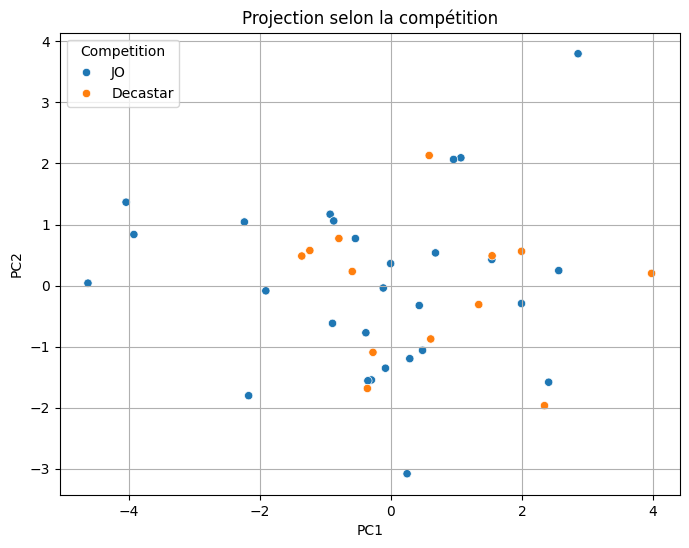

In [112]:
import matplotlib.patches as mpatches

# Coloration selon la compétition
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df["Competition"])
plt.title("Projection selon la compétition")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid()
plt.show()

* Les compétitions (JO / Décastar) n’ont peut-être pas un grand effet sur la performance de athlètes